<h1><center>Named Entity Recognition Model using  Clinical BERT </center></h1>
<h4><center>Final Project W266</center></h4>


<h3><center>SUMMARY</center></h3>

In this notebook, we will look at implementing various BERT models to understand the significance of domain specific contexts with respect to fine tuning NER task.

- The various BERT models used in the notebook are listed below.

__BERT:__ 
>"BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding", by Devlin/Chang/Lee/Toutanova, Google AI Language)

__BioBERT:__ 
>A pre-trained biomedical language representation model for biomedical text mining by Jinhyuk Lee, Wonjin Yoon, Sungdong Kim, Donghyeon Kim, Sunkyu Kim, Chan Ho So, Jaewoo Kang

__SciBERT:__
>A Pretrained Language Model for Scientific Text by Iz Beltagy, Kyle Lo, Arman Cohan

__ClinicalBert:__
>Modeling Clinical Notes and Predicting Hospital Readmission by Kexin Huang, Jaan Altosaar, Rajesh Ranganath

>Publicly Available Clinical BERT Embeddings by Emily Alsentzer, John R. Murphy, Willie Boag, Wei-Hung Weng, Di Jin, Tristan Naumann, Matthew B. A. McDermott


Models used and their corresponding Corpora used:


__Base Bert Cased -__  

>Wikipedia + BookCorpus

__BioBert Cased with PubMed and PMC - __

>English Wikipedia, General BooksCorpus, General PubMed Abstracts, PMC Full-text articles

__SciBert Cased -__

>1.14M papers from Semantic Scholar (Ammar et al., 2018)

__biobert_pretrain_output_all_notes_150000__

>MIMIC text from all note types on BioBert


__biobert_pretrain_output_disch_100000__

>MIMIC text from all discharge summaries on BioBert


We look at the effect of also fine-tuning BERT layers which are pre-trained with clinical context. 


### 1. Data



In [1]:
!tail -20 'ner_dataset.csv'

",",",",O
M.D,NNP,O
JA25,NNP,O
Attending:,NNP,O
SYDNEY,NNP,O
DUESTERHAUS,NNP,O
",",",",O
M.D,NNP,O
MG85,NNP,O
EQ681/3978,NNP,O
Batch:,NNP,O
37609,CD,O
Index,NNP,O
No,NNP,O
FHOW8875S8,NNP,O
D:,NNP,O
6/10,CD,O
T:,NNP,O
1/22,CD,O
[report_end],NN,O


The file consists of words, POS tags and NER tags

In [2]:
!pip install seqeval[gpu]

### Import required libraries

In [3]:
import warnings 
warnings.filterwarnings('ignore')
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
#import tensorflow_hub as hub
from time import time
import io
import re
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

from sklearn.model_selection import train_test_split

from tqdm import tqdm, trange


from datetime import datetime
import os
import sys
import zipfile



In [4]:

# Define maximam length of input 'sentences' (post tokenization).
max_word = 40
max_length = 64
bs = 32

In [5]:

import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

Using TensorFlow backend.


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

#### Print out the device the training was done on

In [6]:
torch.cuda.get_device_name(0) 

'Tesla P100-PCIE-16GB'

## Data Preprocessing 

### BERT Tokenizer

Import tokenizer

In [8]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

#### Sample tokenizer

In [9]:
tokenizer.tokenize('I\'ll learn to swim in 12342 years.')

['I', "'", 'll', 'learn', 'to', 'swim', 'in', '123', '##42', 'years', '.']

Note how the "I'll" phrase and the number '12342' got split. This already highlights an area one needs to address: splitting of tokens will need to be accounted for in the labeling.

In [10]:
tokenizer.convert_tokens_to_ids([
    '[CLS]', 'i', "'",'ll', 'learn','to','swim','in','123', '##42', 'years', '.'])

[101, 178, 112, 1325, 3858, 1106, 11231, 1107, 13414, 23117, 1201, 119]

In [11]:
tokenizer.convert_ids_to_tokens([20958])

['Faye']

### Extraction<a id="extract"/>


We have seen above how the data set looks. We can now turn to the pre-processing and creating the input for BERT. Specifically, we need to:

1) Tokenize the sentences. Note again that one word can be split into multiple tokens, and we need to insert custom labels when that happens to make sure we don't mess up the alignment. We choose a new 'nerX' label here.

2) Create BERT tokens and add [CLS], [PAD], etc.

3) Convert these tokens into ids, also via the tokenizer. These qill create the sentence_ids.

4) Create the mask ids. Mask out all of the padding tokens.

5) Create the sequence ids. In our case, they are all '0' as we do not compare or even have multiple sentences in one example.

To do this, we first define a helper function:

*This section was used from the lecture notebook for BERT

In [12]:
def addWord(word, pos, ner):
    """
    Convert a word into a word token and add supplied NER and POS labels. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, pos label, ner label
    returns: dictionary with tokens and labels
    """
    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc. 
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['posToken'] = [pos] + ['posX'] * (tokenLength - 1)
    addDict['nerToken'] = [ner] + ['nerX'] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength
    
    
    return addDict


Let's see what it does:

In [13]:
addWord('protest', 'VB', 'O')

{'wordToken': ['protest'],
 'posToken': ['VB'],
 'nerToken': ['O'],
 'tokenLength': 1}

In [14]:
addWord('Iraq', 'NNP', 'B-geo')

{'wordToken': ['Iraq'],
 'posToken': ['NNP'],
 'nerToken': ['B-geo'],
 'tokenLength': 1}

In [15]:
addWord('10000', 'CD', 'O')

{'wordToken': ['1000', '##0'],
 'posToken': ['CD', 'posX'],
 'nerToken': ['O', 'nerX'],
 'tokenLength': 2}

#### Preprocessing steps to build out sentences

In [16]:
"""
Read the file line by line and construct sentences. A sentence end is marked by the word 'sentence' in the next row.
You need to take care of that. Also, you need to cap sentence length using max_length. Sentences which are shorter than 
max_length need to be padded. Also, we choose to end all sentences with a [SEP] token, padded or not. 
"""

with io.open('ner_dataset.csv', 'r', encoding='utf-8', errors='ignore') as train:
    text = train.readlines()


# lists for sentences, tokens, labels, etc.  
sentenceList = []
word_count = 0
sentenceTokenList = []
posTokenList = []
nerTokenList = []
sentLengthList = []

# lists for BERT input
bertSentenceIDs = []
bertMasks = []
bertSequenceIDs = []

sentence = ''

# always start with [CLS] tokens
sentenceTokens = ['[CLS]']
posTokens = ['[posCLS]']
nerTokens = ['[nerCLS]']

for line in text:
    
    cleanLine = re.sub(r'(?!(([^"]*"){2})*[^"]*$),', '', line)  # deal with '"10,000"' and convert them to '10000' 

    word, pos, ner = cleanLine.split(',')
    
    ner = ner[:-1]   # remove DOS token
    
    # if new sentence starts
    if (word_count >= max_word -1):            
            
        sentenceLength = min(max_length -1, len(sentenceTokens))
        sentLengthList.append(sentenceLength)
        
                    
        # Create space for at least a final '[SEP]' token
        if sentenceLength >= max_length - 1: 
            sentenceTokens = sentenceTokens[:max_length - 2]
            posTokens = posTokens[:max_length - 2]
            nerTokens = nerTokens[:max_length - 2]

        # add a ['SEP'] token and padding
        
        sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))
        
        posTokens += ['[posSEP]'] + ['[posPAD]'] * (max_length - 1 - len(posTokens) )
        nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )
            
        sentenceList.append(sentence)

        sentenceTokenList.append(sentenceTokens)

        bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
        bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
        bertSequenceIDs.append([0] * (max_length))
                             
        posTokenList.append(posTokens)
        nerTokenList.append(nerTokens)
        
        sentence = ''
        sentenceTokens = ['[CLS]']
        posTokens = ['[posCLS]']
        nerTokens = ['[nerCLS]']
        
        sentence += ' ' + word
        word_count = 0
    
    word_count += 1
    addDict = addWord(word, pos, ner)

    sentenceTokens += addDict['wordToken']
    posTokens += addDict['posToken']
    nerTokens += addDict['nerToken']

# The first two list elements need to be removed. 1st line in file is a-typical, and 2nd line does not end a sentence   
sentLengthList = sentLengthList[2:]
sentenceTokenList = sentenceTokenList[2:]
bertSentenceIDs = bertSentenceIDs[2:]
bertMasks = bertMasks[2:]
bertSequenceIDs = bertSequenceIDs[2:]
posTokenList = posTokenList[2:]
nerTokenList = nerTokenList[2:]

In [17]:
print(sentLengthList[4])

47


In [18]:
print(bertSentenceIDs[4])

[101, 2103, 1115, 1123, 2555, 1125, 1151, 2221, 107, 107, 1105, 1175, 1127, 1185, 2091, 8661, 2879, 1895, 27631, 13066, 1224, 1608, 1109, 5884, 1104, 27631, 20702, 1166, 1103, 1736, 1104, 1103, 1480, 107, 107, 1170, 1134, 1553, 1131, 1108, 2752, 1171, 1106, 2001, 10805, 8643, 3875, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [19]:
print(sentenceTokenList[4])

['[CLS]', 'reported', 'that', 'her', 'foot', 'had', 'been', 'blue', '"', '"', 'and', 'there', 'were', 'no', 'Do', '##pp', '##ler', '##able', 'pulses', 'Color', 'later', 'returned', 'The', 'absence', 'of', 'pulses', 'persisted', 'over', 'the', 'course', 'of', 'the', 'night', '"', '"', 'after', 'which', 'point', 'she', 'was', 'referred', 'back', 'to', 'La', '##rg', '##rine', 'Medical', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [20]:
print(nerTokenList[4])

['[nerCLS]', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'O', 'O', 'O', 'O', 'O', 'nerX', 'nerX', 'nerX', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'nerX', 'O', '[nerSEP]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]']


In [21]:
print(bertMasks[4])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


This looks right. Everything past the '[SEP]' token, i.e., the '[nerSEP]' label, is masked out. Also the sequence_ids are correct: there is only one sentence, so all ids should have the same value of zero.

In [22]:
print(bertSequenceIDs[4])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Looks reasonable. 


### III.3. Initial Data Analysis<a id="analysis" />

It is important to understand the dataset prior to doing any modeling or training. First, what are the length of the original sentences.

(array([   5.,    0.,    7.,    0.,    0.,   21.,    0.,    0.,   31.,
           0.,   44.,    0.,    0.,   51.,    0.,    0.,   69.,    0.,
          85.,    0.,    0.,  108.,    0.,    0.,  128.,    0.,  149.,
           0.,    0.,  163.,    0.,    0.,  169.,    0.,    0.,  178.,
           0.,  201.,    0.,    0.,  208.,    0.,    0.,  228.,    0.,
         228.,    0.,    0.,  224.,    0.,    0.,  222.,    0.,  192.,
           0.,    0.,  179.,    0.,    0.,  186.,    0., 4412.]),
 array([40.        , 40.37096774, 40.74193548, 41.11290323, 41.48387097,
        41.85483871, 42.22580645, 42.59677419, 42.96774194, 43.33870968,
        43.70967742, 44.08064516, 44.4516129 , 44.82258065, 45.19354839,
        45.56451613, 45.93548387, 46.30645161, 46.67741935, 47.0483871 ,
        47.41935484, 47.79032258, 48.16129032, 48.53225806, 48.90322581,
        49.27419355, 49.64516129, 50.01612903, 50.38709677, 50.75806452,
        51.12903226, 51.5       , 51.87096774, 52.24193548, 52.6129032

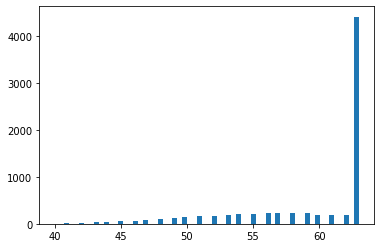

In [23]:
sentenceLengths= [l for l in sentLengthList]

plt.hist(np.array(sentenceLengths), bins=(max_length-2))

In [24]:
numSentences = len(bertSentenceIDs)

nerClasses = pd.DataFrame(np.array(nerTokenList).reshape(-1))
nerClasses.columns = ['tag']
nerClasses.tag = pd.Categorical(nerClasses.tag)
nerClasses['cat'] = nerClasses.tag.cat.codes
nerClasses['sym'] = nerClasses.tag.cat.codes
nerLabels = np.array(nerClasses.cat).reshape(numSentences, -1) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd029d41e48>]],
      dtype=object)

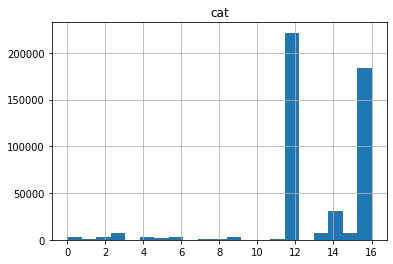

In [25]:
nerClasses[['cat']].hist(bins=21)

Looks like a lot of tables with value 16+... Let's see which labels these label numbers corresponds to:

In [26]:
nerDistribution = (nerClasses.groupby(['tag', 'cat']).agg({'sym':'count'}).reset_index()
                   .rename(columns={'sym':'occurences'}))

numNerClasses = nerDistribution.tag.nunique()

nerDistribution

,tag,cat,occurences
0,B-do,0,3520
1,B-du,1,485
2,B-f,2,3171
3,B-m,3,7443
4,B-mo,4,2664
5,B-r,5,1479
6,I-do,6,3146
7,I-du,7,1020
8,I-f,8,1109
9,I-m,9,3321


Interesting. 12 corresponds to 'O', and all 'extension' labels (i.e., those that were not part of the original data) occur at 13+. 

'O' is the most common token - by far.

### III.4. Baseline: Always picking 'Other'<a id="baseline" />

Let's see what a baseline would give for the actual text tokens, if I ALWAYS chose the most common token 'O':

In [27]:
O_occurences = nerDistribution.loc[nerDistribution.tag == 'O','occurences']
All_occurences = nerDistribution[nerDistribution.cat < 13]['occurences'].sum()

O_occurences/All_occurences

12    0.885908
Name: occurences, dtype: float64

So **88.5%** is the baseline

### III.5. Train/Test Split and Final Data Preparation<a id="split" />

In the last step we need to prepare both labels and input for the model, including the train/test split.

In [28]:
bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])



In [29]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(bertSentenceIDs, nerLabels, 
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(bertMasks, bertSentenceIDs,
                                             random_state=2018, test_size=0.1)

In [30]:
print(tr_masks[6])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [31]:
print(tr_inputs[6])

[101, 1132, 15498, 125, 5135, 13335, 8643, 131, 1109, 5351, 1144, 170, 1607, 1104, 17972, 17972, 1335, 1148, 107, 107, 1119, 1108, 1113, 1117, 1313, 13753, 1104, 151, 2101, 3048, 26825, 1134, 1108, 1406, 2338, 4841, 12734, 13064, 3828, 1112, 1218, 1112, 1126, 26825, 7989, 3418, 2279, 1104, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [32]:
tr_tags[6]

array([13, 12, 12, 12, 12, 16, 16, 16, 12, 12, 12, 12, 12, 12,  5,  5, 12,
       12, 12, 16, 12, 12, 12, 12, 12, 12, 12,  3, 16, 16,  9, 12, 12,  0,
        6,  4, 16, 16,  2, 12, 12, 12, 12,  3,  0,  6, 12, 12, 15, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14], dtype=int8)

In [33]:
print(sentenceTokenList[6])

['[CLS]', 'on', 'the', '2', 'of', 'September', 'PA', '##ST', 'S', '##UR', '##GI', '##CA', '##L', 'H', '##IS', '##TO', '##R', '##Y', ':', 'Notable', 'for', 'the', 'above', '"', '"', 'as', 'well', 'as', 'de', '##bri', '##de', '##ments', 'of', 'her', 'toe', 'am', '##putation', 'wound', 'site', 'AD', '##MI', '##SS', '##ION', 'ME', '##DI', '##CA', '##TI', '##ON', '##S', ':', 'Cola', '##ce', '100', 'mg', 'b', '.', 'i', '.', 'd', '"', '"', 'insulin', '[SEP]', '[PAD]']


In [36]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags, dtype=torch.long, device=device)
val_tags = torch.tensor(val_tags, dtype=torch.long, device=device)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [37]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [38]:
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=nerDistribution['tag'].count())


In [39]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=2e-5)

In [40]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementw

In [43]:
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [48]:
epochs = 50
max_grad_norm = 1.0

train_loss = []
evaluation_loss = []
f1score = []
for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    train_loss.append(tr_loss/nb_tr_steps)
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    evaluation_loss.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == p_i).idxmax()][0] for p in predictions for p_i in p])
    valid_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][0] for l in true_labels for l_i in l for l_ii in l_i])
    valid_ids = [nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][1] for l in true_labels for l_i in l for l_ii in l_i]
    mask = (np.array(valid_ids) < 13)
    #print(mask)
    pred = np.ma.compressed(np.ma.MaskedArray(pred_tags, mask=~mask))
    valid = np.ma.compressed(np.ma.MaskedArray(valid_tags, mask=~mask))
    #print(pred.tolist())
    print("F1-Score: {}".format(f1_score(pred.tolist(), valid.tolist())))
    f1score.append(f1_score(pred.tolist(), valid.tolist()))
    print("Recall: {}".format(recall_score(pred.tolist(), valid.tolist())))
    

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.002687076397292025
Validation loss: 0.08115194241205852
Validation Accuracy: 0.9803216396233975


Epoch:   2%|▏         | 1/50 [02:40<2:11:08, 160.58s/it]

F1-Score: 0.8725910064239828
Recall: 0.8670212765957447
Train loss: 0.0027321138448452675
Validation loss: 0.08252528651307027
Validation Accuracy: 0.9838726337139424


Epoch:   4%|▍         | 2/50 [05:21<2:08:39, 160.82s/it]

F1-Score: 0.8597093791281374
Recall: 0.8434421980300674
Train loss: 0.002527289191576524
Validation loss: 0.08029698890944321
Validation Accuracy: 0.9831402118389424


Epoch:   6%|▌         | 3/50 [08:02<2:05:55, 160.76s/it]

F1-Score: 0.8687083888149134
Recall: 0.8588730911005793
Train loss: 0.002503504164343682
Validation loss: 0.08320747649607559
Validation Accuracy: 0.9836378831129808


Epoch:   8%|▊         | 4/50 [10:43<2:03:10, 160.67s/it]

F1-Score: 0.8569174118884797
Recall: 0.8371017471736896
Train loss: 0.0020693073663885387
Validation loss: 0.08786290014783542
Validation Accuracy: 0.9832106370192308


Epoch:  10%|█         | 5/50 [13:23<2:00:27, 160.61s/it]

F1-Score: 0.8491794738213078
Recall: 0.821986888552698
Train loss: 0.0019705477910655906
Validation loss: 0.08977469506983955
Validation Accuracy: 0.9832716721754808


Epoch:  12%|█▏        | 6/50 [16:04<1:57:53, 160.77s/it]

F1-Score: 0.8498319979322823
Recall: 0.8166915052160953
Train loss: 0.0020004819520810947
Validation loss: 0.08588971686549485
Validation Accuracy: 0.9851324619391025


Epoch:  14%|█▍        | 7/50 [18:45<1:55:15, 160.83s/it]

F1-Score: 0.8699973842532042
Recall: 0.8454499237417387
Train loss: 0.0018003616705194769
Validation loss: 0.09186652155282597
Validation Accuracy: 0.9831715119190706


Epoch:  16%|█▌        | 8/50 [21:26<1:52:37, 160.89s/it]

F1-Score: 0.8704051515964583
Recall: 0.8669160876536611
Train loss: 0.001961052030956944
Validation loss: 0.08803663480406006
Validation Accuracy: 0.9844109950921475


Epoch:  18%|█▊        | 9/50 [24:07<1:49:52, 160.79s/it]

F1-Score: 0.8685956994956199
Recall: 0.8560962846677133
Train loss: 0.0018197188926424822
Validation loss: 0.08630045394723614
Validation Accuracy: 0.983547112880609


Epoch:  20%|██        | 10/50 [26:48<1:47:18, 160.97s/it]

F1-Score: 0.8716838115863562
Recall: 0.8759521218715995
Train loss: 0.001715158263866357
Validation loss: 0.08974979336683948
Validation Accuracy: 0.9794687124399039


Epoch:  22%|██▏       | 11/50 [29:28<1:44:29, 160.75s/it]

F1-Score: 0.8640419947506561
Recall: 0.842374616171955
Train loss: 0.0015336422688508146
Validation loss: 0.08732165365169446
Validation Accuracy: 0.9867318960336539


Epoch:  24%|██▍       | 12/50 [32:08<1:41:35, 160.40s/it]

F1-Score: 0.863107822410148
Recall: 0.8469917012448133
Train loss: 0.0015888622001511976
Validation loss: 0.09555970830842853
Validation Accuracy: 0.9862123147035257


Epoch:  26%|██▌       | 13/50 [34:48<1:38:49, 160.25s/it]

F1-Score: 0.8545548654244306
Recall: 0.8222111553784861
Train loss: 0.0010946433541463728
Validation loss: 0.09892470731089513
Validation Accuracy: 0.9868727463942308


Epoch:  28%|██▊       | 14/50 [37:28<1:36:04, 160.12s/it]

F1-Score: 0.8630968082300186
Recall: 0.8454780361757106
Train loss: 0.0015564987368901564
Validation loss: 0.09782079351134598
Validation Accuracy: 0.9873406825921475


Epoch:  30%|███       | 15/50 [40:07<1:33:20, 160.01s/it]

F1-Score: 0.8747357293868923
Recall: 0.858402489626556
Train loss: 0.0019856509541706746
Validation loss: 0.08778160880319774
Validation Accuracy: 0.987209222255609


Epoch:  32%|███▏      | 16/50 [42:47<1:30:39, 159.99s/it]

F1-Score: 0.8702049395691015
Recall: 0.8492307692307692
Train loss: 0.0015537587896343077
Validation loss: 0.09161519693831603
Validation Accuracy: 0.9873907627203525
F1-Score: 0.8723068838675775


Epoch:  34%|███▍      | 17/50 [45:28<1:28:08, 160.26s/it]

Recall: 0.8512820512820513
Train loss: 0.001146170796372131
Validation loss: 0.09073624177835882
Validation Accuracy: 0.9874314528245192


Epoch:  36%|███▌      | 18/50 [48:09<1:25:34, 160.44s/it]

F1-Score: 0.871578947368421
Recall: 0.8518518518518519
Train loss: 0.0010359183156285468
Validation loss: 0.0956356314321359
Validation Accuracy: 0.9873798076923076


Epoch:  38%|███▊      | 19/50 [50:50<1:22:54, 160.45s/it]

F1-Score: 0.8741370154009559
Recall: 0.8617801047120419
Train loss: 0.0009364280955213832
Validation loss: 0.0985661616238455
Validation Accuracy: 0.9877178485576924


Epoch:  40%|████      | 20/50 [53:30<1:20:10, 160.36s/it]

F1-Score: 0.8747334754797442
Recall: 0.865506329113924
Train loss: 0.0010716958710497854
Validation loss: 0.10029521537944674
Validation Accuracy: 0.9870464618389424


Epoch:  42%|████▏     | 21/50 [56:10<1:17:29, 160.34s/it]

F1-Score: 0.8769395398608881
Recall: 0.8708820403825718
Train loss: 0.0015425786347171486
Validation loss: 0.09576202533207834
Validation Accuracy: 0.9871982672275642


Epoch:  44%|████▍     | 22/50 [58:51<1:14:57, 160.63s/it]

F1-Score: 0.8707194053623573
Recall: 0.858189429618001
Train loss: 0.0013166963452892874
Validation loss: 0.09105453787681957
Validation Accuracy: 0.9872796474358975


Epoch:  46%|████▌     | 23/50 [1:01:33<1:12:22, 160.83s/it]

F1-Score: 0.8770448548812665
Recall: 0.859358841778697
Train loss: 0.0011534014101494965
Validation loss: 0.09318098061097164
Validation Accuracy: 0.987148187099359


Epoch:  48%|████▊     | 24/50 [1:04:14<1:09:49, 161.13s/it]

F1-Score: 0.8805570433851098
Recall: 0.8753993610223643
Train loss: 0.0012813758199040832
Validation loss: 0.09441493032500148
Validation Accuracy: 0.9867929311899039


Epoch:  50%|█████     | 25/50 [1:06:56<1:07:12, 161.31s/it]

F1-Score: 0.8729693741677762
Recall: 0.8630858346498157
Train loss: 0.0013732047697510713
Validation loss: 0.09412286927302678
Validation Accuracy: 0.9873109475160257


Epoch:  52%|█████▏    | 26/50 [1:09:38<1:04:34, 161.43s/it]

F1-Score: 0.8738642437199359
Recall: 0.866914103923648
Train loss: 0.0009442285653336141
Validation loss: 0.09765925242876013
Validation Accuracy: 0.9869353465544872


Epoch:  54%|█████▍    | 27/50 [1:12:19<1:01:50, 161.31s/it]

F1-Score: 0.8691184424012981
Recall: 0.8724212812160695
Train loss: 0.0009584201273127123
Validation loss: 0.09561188674221437
Validation Accuracy: 0.9866098257211539


Epoch:  56%|█████▌    | 28/50 [1:15:00<59:06, 161.19s/it]  

F1-Score: 0.8689473684210527
Recall: 0.8492798353909465
Train loss: 0.0010946159586314524
Validation loss: 0.09871012531220913
Validation Accuracy: 0.9867397210536858


Epoch:  58%|█████▊    | 29/50 [1:17:41<56:25, 161.20s/it]

F1-Score: 0.8716591690923525
Recall: 0.8564742589703588
Train loss: 0.0009195892835381856
Validation loss: 0.1042994645734628
Validation Accuracy: 0.9861512795472757


Epoch:  60%|██████    | 30/50 [1:20:23<53:45, 161.30s/it]

F1-Score: 0.8632456368846053
Recall: 0.8356026222894604
Train loss: 0.000935608086167113
Validation loss: 0.09655407800649603
Validation Accuracy: 0.9861825796274039


Epoch:  62%|██████▏   | 31/50 [1:23:03<50:57, 160.93s/it]

F1-Score: 0.870687384777456
Recall: 0.8516228748068007
Train loss: 0.0007609455074929584
Validation loss: 0.10055757686495781
Validation Accuracy: 0.987026116786859


Epoch:  64%|██████▍   | 32/50 [1:25:44<48:17, 160.96s/it]

F1-Score: 0.8757648310720937
Recall: 0.8649500788229112
Train loss: 0.0012292030435747227
Validation loss: 0.10013174389799435
Validation Accuracy: 0.9867929311899039


Epoch:  66%|██████▌   | 33/50 [1:28:25<45:36, 160.94s/it]

F1-Score: 0.8660998937300743
Recall: 0.8542976939203354
Train loss: 0.001119986703109768
Validation loss: 0.09528725539955
Validation Accuracy: 0.9876552483974358


Epoch:  68%|██████▊   | 34/50 [1:31:05<42:52, 160.80s/it]

F1-Score: 0.8717675286590243
Recall: 0.862796833773087
Train loss: 0.0009854011299104874
Validation loss: 0.09979434008710086
Validation Accuracy: 0.9845941005608975


Epoch:  70%|███████   | 35/50 [1:33:45<40:07, 160.47s/it]

F1-Score: 0.871605589243343
Recall: 0.853381517811048
Train loss: 0.0011278492170039805
Validation loss: 0.0995892914167295
Validation Accuracy: 0.984706780849359


Epoch:  72%|███████▏  | 36/50 [1:36:24<37:22, 160.18s/it]

F1-Score: 0.8620424878423343
Recall: 0.8210628961482204
Train loss: 0.0008044515245911882
Validation loss: 0.10124869512704511
Validation Accuracy: 0.9858539287860576


Epoch:  74%|███████▍  | 37/50 [1:39:04<34:42, 160.21s/it]

F1-Score: 0.865010799136069
Recall: 0.8668831168831169
Train loss: 0.0007366832610710344
Validation loss: 0.0992599919748803
Validation Accuracy: 0.9859979091546475


Epoch:  76%|███████▌  | 38/50 [1:41:44<32:01, 160.10s/it]

F1-Score: 0.8705321683876093
Recall: 0.855804268610099
Train loss: 0.0006450086442506911
Validation loss: 0.09963661890166502
Validation Accuracy: 0.9851230719150642


Epoch:  78%|███████▊  | 39/50 [1:44:25<29:23, 160.34s/it]

F1-Score: 0.8678851174934726
Recall: 0.8419452887537994
Train loss: 0.0006301955944380278
Validation loss: 0.10360799861761431
Validation Accuracy: 0.9874017177483975


Epoch:  80%|████████  | 40/50 [1:47:07<26:47, 160.77s/it]

F1-Score: 0.8707627118644067
Recall: 0.85625
Train loss: 0.0010024711930597013
Validation loss: 0.09899961374079187
Validation Accuracy: 0.9881231845953525


Epoch:  82%|████████▏ | 41/50 [1:49:48<24:07, 160.84s/it]

F1-Score: 0.8740939597315437
Recall: 0.8710540395933655
Train loss: 0.0012585281463767793
Validation loss: 0.099741987651214
Validation Accuracy: 0.9868649213741988


Epoch:  84%|████████▍ | 42/50 [1:52:29<21:27, 160.92s/it]

F1-Score: 0.8696109358569927
Recall: 0.8490759753593429
Train loss: 0.0005542039308751537
Validation loss: 0.10570020259668429
Validation Accuracy: 0.9871794871794872


Epoch:  86%|████████▌ | 43/50 [1:55:10<18:46, 160.97s/it]

F1-Score: 0.8717948717948718
Recall: 0.864406779661017
Train loss: 0.0007637784235644671
Validation loss: 0.1086125043220818
Validation Accuracy: 0.9871184520232372


Epoch:  88%|████████▊ | 44/50 [1:57:51<16:05, 160.92s/it]

F1-Score: 0.869198312236287
Recall: 0.8512396694214877
Train loss: 0.0006528228948214721
Validation loss: 0.1111917954403907
Validation Accuracy: 0.9866192157451924


Epoch:  90%|█████████ | 45/50 [2:00:32<13:24, 160.88s/it]

F1-Score: 0.8743372216330858
Recall: 0.8606471816283925
Train loss: 0.0008410526259734832
Validation loss: 0.10878300565915804
Validation Accuracy: 0.9868117112379808


Epoch:  92%|█████████▏| 46/50 [2:03:13<10:43, 160.90s/it]

F1-Score: 0.8639744952178533
Recall: 0.8522012578616353
Train loss: 0.000781404928331014
Validation loss: 0.10098052327521145
Validation Accuracy: 0.9869353465544872


Epoch:  94%|█████████▍| 47/50 [2:05:54<08:02, 160.95s/it]

F1-Score: 0.864366605214643
Recall: 0.8454404945904173
Train loss: 0.0005706037737448315
Validation loss: 0.10885998366090159
Validation Accuracy: 0.9867506760817308


Epoch:  96%|█████████▌| 48/50 [2:08:35<05:21, 160.92s/it]

F1-Score: 0.8732394366197184
Recall: 0.8615626638699528
Train loss: 0.0005573777234056863
Validation loss: 0.10791433920773368
Validation Accuracy: 0.986476800380609


Epoch:  98%|█████████▊| 49/50 [2:11:16<02:40, 160.98s/it]

F1-Score: 0.8691960732289732
Recall: 0.8562467328802927
Train loss: 0.00047451683973786076
Validation loss: 0.11021817351380984
Validation Accuracy: 0.9870558518629808


Epoch: 100%|██████████| 50/50 [2:13:57<00:00, 160.99s/it]

F1-Score: 0.8682874699438953
Recall: 0.8611552729199788


In [49]:
!pip install scipy

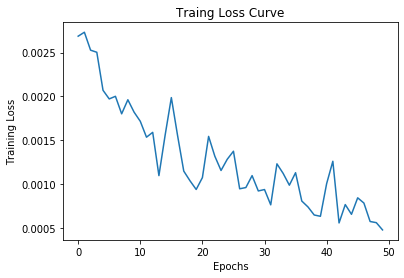

In [50]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Traing Loss Curve")
plt.show()

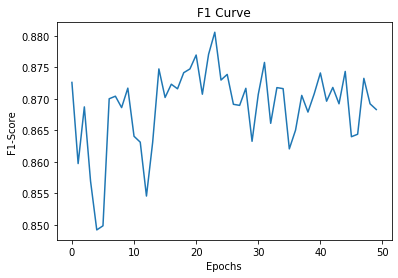

In [51]:
import matplotlib.pyplot as plt

plt.plot(f1score)
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.title("F1 Curve")
plt.show()